<a href="https://colab.research.google.com/github/sdannels/synthetic_time_series_forecasting/blob/main/synthetic_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi statsmodels datetime keras math

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import datetime as dt
import torch
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import load_model
#from gretel_synthetics.timeseries_dgan.dgan import DGAN
#from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# read in economic data and convert to DateTime index
df = pd.read_csv("/content/drive/MyDrive/Synthetic_data/fred_data", index_col = 0)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'date'
df = df.reset_index()
# create lag of 1 and 10-year yield
df['DGS1_lag'] = df['DGS1'].shift(1)
df['DGS10_lag'] = df['DGS10'].shift(1)

In [4]:
# function to plot forecasting results
def plot_forecast_compare(compare_df, forecast_var_name, actual_var_name, title,
                          RMSE = True, MAPE = True):
  """
  compare_df is dataframe with forecasted, actual, and date values
  forecast_var_name, actual_var_name are strings for column names in compare_df
  title is a string for the title of the graph
  RMSE and MAPE: True if want to output those statistics above graph
  """
  # print RMSE
  if RMSE == True:
    model_rmse = math.sqrt(mean_squared_error(compare_df[actual_var_name], compare_df[forecast_var_name]))
    print(f'RMSE: {model_rmse}')
  
  # print MAPE
  if MAPE == True:
    model_mape = mean_absolute_percentage_error(compare_df[actual_var_name], compare_df[forecast_var_name])*100
    print(f'MAPE: {model_mape}')

  # plot results
  plt.plot(compare_df['date'], compare_df[actual_var_name], label = 'Actual')
  plt.plot(compare_df['date'], compare_df[forecast_var_name], label = 'Forecast')
  plt.title(title)
  plt.legend()
  plt.xticks(rotation = 45)
  plt.show()

# Autoregressive Model

In [5]:
# set last date for training data and first date for forecasting (next day)
last_train_date = '12-31-2016'
start_forecast_date = dt.datetime.strptime(last_train_date, '%m-%d-%Y') + dt.timedelta(days = 3)
start_forecast_date = start_forecast_date.strftime('%m-%d-%Y')
end_forecast_date = '01-11-2023'

# split up training and testing data
train_df = df[df['date'] <= last_train_date]
test_df = df[df['date'] > last_train_date]

## 1-year Treasury Yield

In [6]:
# choose optimal number of lags by BIC
opt_mod = ar_select_order(train_df['DGS1'], exog = train_df['DGS10_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod = AutoReg(train_df['DGS1'], exog = train_df['DGS10_lag'], lags = 13, trend = 'c',
              missing = 'drop', old_names = False)
res = mod.fit(cov_type="HC0")
print(res.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Chosen lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
                            AutoReg Model Results                             
Dep. Variable:                   DGS1   No. Observations:                13734
Model:                  AutoReg-X(13)   Log Likelihood               14775.944
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Thu, 19 Jan 2023   AIC                             -4.989
Time:                        08:20:35   BIC                             -4.981
Sample:                            13   HQIC                            -4.986
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.325      0.745      -0.004       0.005
DGS1.L1        1.1031      0.021     51.607      0.000       1.061       1.14

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [7]:
# find start and end index numbers
df_index = df.copy()
start_forecast_index = df_index.index[df_index['date'] == start_forecast_date][0]
end_forecast_index = df_index.index[df_index['date'] == end_forecast_date][0]
del df_index

# forecast
ar_preds = res.predict(start = start_forecast_index, end = end_forecast_index, 
                       exog_oos = test_df['DGS10_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.2093689916881336
MAPE: 535.1963216815966


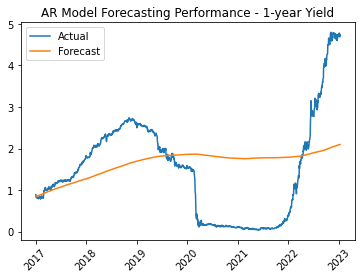

In [8]:
# compare forecasts to actuals
actuals = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), 'DGS1']
actuals_df = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS1']]
ar_compare = pd.concat([actuals_df, ar_preds], axis = 1)
ar_compare.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 1-year Yield')

## 10-year Treasury Yield

In [9]:
# choose optimal number of lags by BIC
opt_mod10 = ar_select_order(train_df['DGS10'], exog = train_df['DGS1_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod10.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod10 = AutoReg(train_df['DGS10'], exog = train_df['DGS1_lag'], lags = 2, trend = 'c',
              missing = 'drop', old_names = False)
res10 = mod10.fit(cov_type="HC0")
print(res10.summary())

Chosen lags: [1 2]
                            AutoReg Model Results                             
Dep. Variable:                  DGS10   No. Observations:                13734
Model:                   AutoReg-X(2)   Log Likelihood               17774.416
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Thu, 19 Jan 2023   AIC                             -5.426
Time:                        08:20:45   BIC                             -5.423
Sample:                             2   HQIC                            -5.425
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.203      0.028       0.000       0.008
DGS10.L1       1.0685      0.015     70.076      0.000       1.039       1.098
DGS10.L2      -0.0703      0.015 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [10]:
# forecast
ar_preds_10 = res10.predict(start = start_forecast_index, end = end_forecast_index, 
                            exog_oos = test_df['DGS1_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.3037903165314702
MAPE: 85.31142329159722


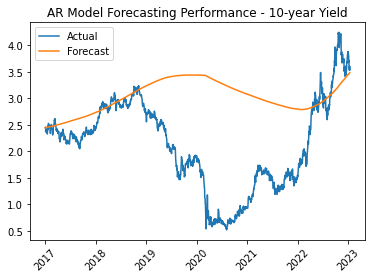

In [11]:
# compare forecasts to actuals
actuals_df10 = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS10']]
ar_compare10 = pd.concat([actuals_df10, ar_preds_10], axis = 1)
ar_compare10.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare10,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 10-year Yield')

# LSTM Neural Network (Real Data)

Parts of code adapted from examples in: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [12]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for NN
def split_NN_samples(data, n_steps):
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [13]:
# select features from df and # of steps for each sample
feature_cols = ['DGS1', 'DGS10']
n_steps = 25

# format training data
train_data = df_to_np(train_df, feature_cols)
train_x, train_y = split_NN_samples(data = train_data, n_steps = n_steps)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x.shape)
n_features = train_x.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y.shape)

(13710, 25, 2)
(13710, 2)


In [ ]:
# define model
LSTM_model = Sequential()
LSTM_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_model.add(LSTM(100, activation='tanh'))
LSTM_model.add(Dense(n_features))
LSTM_model.compile(optimizer='adam', loss='mse')

In [14]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = load_model("/content/drive/MyDrive/Models/LSTM_model")
else:
  # train model
  LSTM_model.fit(train_x, train_y, epochs = 200, verbose = 0)

In [51]:
# save model after training
LSTM_model.save("/content/drive/MyDrive/Models/LSTM_model")

In [15]:
# format test data
test_df = df[(df['date'] > last_train_date) & (df['date'] <= end_forecast_date)]
test_data = df_to_np(test_df, feature_cols)
test_x, test_y = split_NN_samples(data = test_data, n_steps = n_steps)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x.shape)
# test_y shape is (# of samples, # of features)
print(test_y.shape)

(1482, 25, 2)
(1482, 2)


In [16]:
# forecast on test data
yhat = LSTM_model.predict(test_x, verbose=0)

RMSE: 0.0785175845406574
MAPE: 18.482230576092583


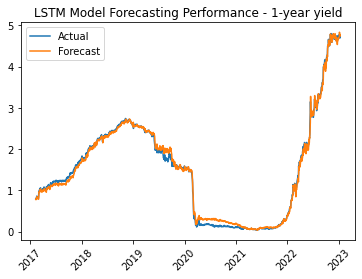

RMSE: 0.1730056764834313
MAPE: 10.673743189138971


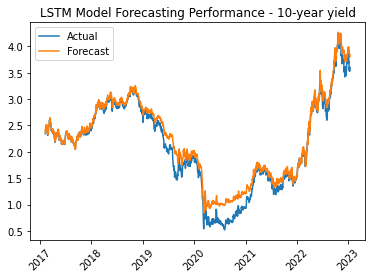

In [17]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_compare = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_y)], axis = 1)
LSTM_compare = pd.concat([date_compare, LSTM_compare], axis = 1)
LSTM_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Synthetic Data)

This model is trained on synthetic data, but tested on the same real data as above.

In [18]:
# load previously trained model
#if torch.cuda.is_available() == True:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt')
#else:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt', map_location = torch.device('cpu'))

# generate synthetic data in numpy array format
# synthetic_attributes, synthetic_features = model.generate_numpy(1000)

# load synthetic data from DGAN_generation notebook
synthetic_features = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped")
### WARNING: ENSURE THAT SHAPE OF DATA HAS NOT CHANGED IN DGAN_Generation NOTEBOOK ###############
synthetic_features = synthetic_features.reshape(1000, 125, 2)
synthetic_attributes = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes")
synthetic_attributes = synthetic_attributes.reshape(-1, 1)

In [19]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples(data = synthetic_features[i, :, :], n_steps = n_steps)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x, synth_train_y = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x = np.concatenate([synth_train_x, synth_train_x_iter], axis = 0)
    synth_train_y = np.concatenate([synth_train_y, synth_train_y_iter], axis = 0)

print(synth_train_x.shape)
print(synth_train_y.shape)

(100000, 25, 2)
(100000, 2)


In [ ]:
# define model (should be same as model used for real data)
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_synth_model.add(LSTM(100, activation='tanh'))
LSTM_synth_model.add(Dense(n_features))
LSTM_synth_model.compile(optimizer='adam', loss='mse')

In [20]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = load_model("/content/drive/MyDrive/Models/LSTM_synth_model")
else:
  # train model
  LSTM_synth_model.fit(synth_train_x, synth_train_y, epochs = 150, verbose = 0)

In [52]:
# save model after training
LSTM_synth_model.save("/content/drive/MyDrive/Models/LSTM_synth_model")

In [21]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_synth = LSTM_synth_model.predict(test_x, verbose=0)

RMSE: 0.07156822325006244
MAPE: 10.130707003617834


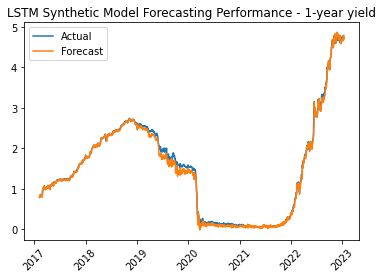

RMSE: 0.11149735365375073
MAPE: 4.511957436625973


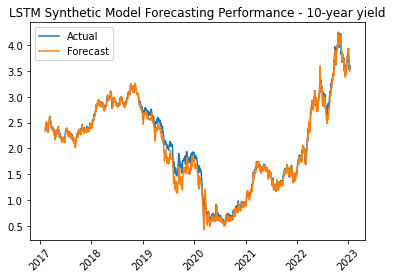

In [22]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_synth_compare = pd.concat([pd.DataFrame(yhat_synth), pd.DataFrame(test_y)], axis = 1)
LSTM_synth_compare = pd.concat([date_compare, LSTM_synth_compare], axis = 1)
LSTM_synth_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 10-year yield')

# Multi-Step LSTM (Real Data)

In [23]:
n_steps_in = 25
# set number of steps ahead to forecast
n_steps_out = 15

# function to split samples for multiple steps ahead
def split_NN_samples_multistep(data, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(data)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
  if out_end_ix > len(data):
    break
  # gather input and output parts of the pattern
  seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [24]:
# create training samples
train_x_multi, train_y_multi = split_NN_samples_multistep(data = train_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x_multi.shape)
n_features_multi = train_x_multi.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y_multi.shape)

(13696, 25, 2)
(13696, 15, 2)


In [25]:
# format test data
test_x_multi, test_y_multi = split_NN_samples_multistep(data = test_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x_multi.shape)
# test_y shape is (# of samples, # of features)
print(test_y_multi.shape)

(1468, 25, 2)
(1468, 15, 2)


In [26]:
# define model
LSTM_model_multi = Sequential()
LSTM_model_multi.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_model_multi.add(LSTM(100, activation='tanh'))
LSTM_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_model_multi.compile(optimizer='adam', loss='mse')

In [27]:
# if true, load a pretrained model instead of training
load_multi_pretrain = True

if load_multi_pretrain == True:
  LSTM_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_model_multi")
else:
  # train model
  LSTM_model_multi.fit(train_x_multi, train_y_multi, epochs = 150, verbose = 0)

Epoch 1/150
428/428 - 4s - loss: 3.6674 - 4s/epoch - 10ms/step
Epoch 2/150
428/428 - 2s - loss: 0.1292 - 2s/epoch - 4ms/step
Epoch 3/150
428/428 - 2s - loss: 0.0904 - 2s/epoch - 4ms/step
Epoch 4/150
428/428 - 2s - loss: 0.0795 - 2s/epoch - 4ms/step
Epoch 5/150
428/428 - 2s - loss: 0.0749 - 2s/epoch - 4ms/step
Epoch 6/150
428/428 - 2s - loss: 0.0712 - 2s/epoch - 4ms/step
Epoch 7/150
428/428 - 2s - loss: 0.0698 - 2s/epoch - 4ms/step
Epoch 8/150
428/428 - 2s - loss: 0.0690 - 2s/epoch - 4ms/step
Epoch 9/150
428/428 - 2s - loss: 0.0673 - 2s/epoch - 4ms/step
Epoch 10/150
428/428 - 2s - loss: 0.0649 - 2s/epoch - 4ms/step
Epoch 11/150
428/428 - 2s - loss: 0.0655 - 2s/epoch - 4ms/step
Epoch 12/150
428/428 - 2s - loss: 0.0653 - 2s/epoch - 4ms/step
Epoch 13/150
428/428 - 2s - loss: 0.0638 - 2s/epoch - 4ms/step
Epoch 14/150
428/428 - 2s - loss: 0.0645 - 2s/epoch - 4ms/step
Epoch 15/150
428/428 - 2s - loss: 0.0612 - 2s/epoch - 4ms/step
Epoch 16/150
428/428 - 2s - loss: 0.0610 - 2s/epoch - 4ms/step


In [28]:
# save model after training
LSTM_model_multi.save("/content/drive/MyDrive/Models/LSTM_model_multi")

In [29]:
# forecast on test data
yhat_multi = LSTM_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.4369073233953562
MAPE: 81.86026238446095


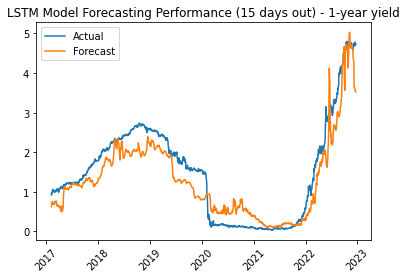

RMSE: 0.1730056764834313
MAPE: 10.673743189138971


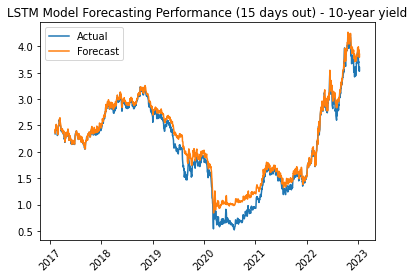

In [47]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_multi_last_day = yhat_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_compare_multi = pd.concat([pd.DataFrame(yhat_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_compare_multi = pd.concat([date_compare, LSTM_compare_multi], axis = 1)
LSTM_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_compare_multi = LSTM_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

# Multi-Step LSTM (Synthetic Data)

In [48]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples_multistep(data = synthetic_features[i, :, :], 
                                                                      n_steps_in = n_steps_in, n_steps_out = n_steps_out)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x_multi, synth_train_y_multi = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x_multi = np.concatenate([synth_train_x_multi, synth_train_x_iter], axis = 0)
    synth_train_y_multi = np.concatenate([synth_train_y_multi, synth_train_y_iter], axis = 0)

print(synth_train_x_multi.shape)
print(synth_train_y_multi.shape)

(86000, 25, 2)
(86000, 15, 2)


In [61]:
# define model (should be the same as model used for real data)
LSTM_synth_model_multi = Sequential()
LSTM_synth_model_multi.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_synth_model_multi.add(LSTM(100, activation='tanh'))
LSTM_synth_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_synth_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_synth_model_multi.compile(optimizer='adam', loss='mse')

In [62]:
# if true, load a pretrained model instead of training
load_synth_multi_pretrain = False

if load_synth_multi_pretrain == True:
  LSTM_synth_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_synth_model_multi")
else:
  # train model
  LSTM_synth_model_multi.fit(synth_train_x_multi, synth_train_y_multi, epochs = 150, verbose = 2)

Epoch 1/150
2688/2688 - 16s - loss: 0.8253 - 16s/epoch - 6ms/step
Epoch 2/150
2688/2688 - 15s - loss: 0.1883 - 15s/epoch - 5ms/step
Epoch 3/150
2688/2688 - 16s - loss: 0.1597 - 16s/epoch - 6ms/step
Epoch 4/150
2688/2688 - 15s - loss: 0.1354 - 15s/epoch - 6ms/step
Epoch 5/150
2688/2688 - 16s - loss: 0.1258 - 16s/epoch - 6ms/step
Epoch 6/150
2688/2688 - 16s - loss: 0.1224 - 16s/epoch - 6ms/step
Epoch 7/150
2688/2688 - 16s - loss: 0.1120 - 16s/epoch - 6ms/step
Epoch 8/150
2688/2688 - 14s - loss: 0.1096 - 14s/epoch - 5ms/step
Epoch 9/150
2688/2688 - 15s - loss: 0.1153 - 15s/epoch - 6ms/step
Epoch 10/150
2688/2688 - 15s - loss: 0.1009 - 15s/epoch - 6ms/step
Epoch 11/150
2688/2688 - 14s - loss: 0.1001 - 14s/epoch - 5ms/step
Epoch 12/150
2688/2688 - 15s - loss: 0.0904 - 15s/epoch - 5ms/step
Epoch 13/150
2688/2688 - 16s - loss: 0.0858 - 16s/epoch - 6ms/step
Epoch 14/150
2688/2688 - 16s - loss: 0.0874 - 16s/epoch - 6ms/step
Epoch 15/150
2688/2688 - 17s - loss: 0.0799 - 17s/epoch - 6ms/step
Epoc

In [63]:
# save model after training
LSTM_synth_model_multi.save("/content/drive/MyDrive/Models/LSTM_synth_model_multi")

In [64]:
# forecast on test data (trained on synthetic data, test on real data)
yhat_synth_multi = LSTM_synth_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.5394293646937445
MAPE: 32.67612290937754


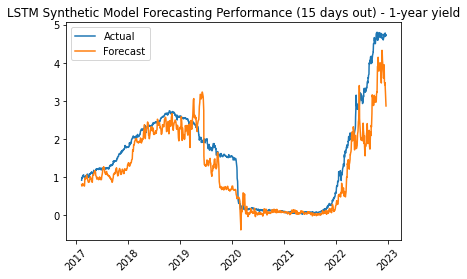

RMSE: 0.854972740843863
MAPE: 23.589719055493024


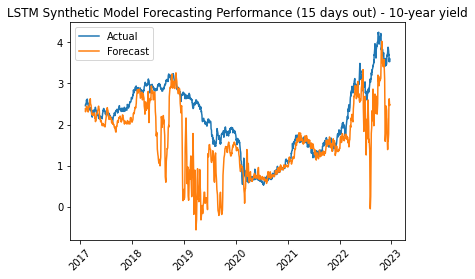

In [65]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_synth_multi_last_day = yhat_synth_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_synth_compare_multi = pd.concat([pd.DataFrame(yhat_synth_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_synth_compare_multi = pd.concat([date_compare, LSTM_synth_compare_multi], axis = 1)
LSTM_synth_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_synth_compare_multi = LSTM_synth_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')